# Анализ цен на БигМак
Цель: Что стоимость бургеров в разных странах может сказать о «силе» их национальных валют? В данной работе необходимо проанализировать датасет, используя полученные теоретические навыки, чтобы понять зависимость от цен на Бик Мак

Аналог индекса – расчет покупательной способности людей в разных странах, когда аналитики сравнивают стоимость какой-то корзины продуктов для жителей целевых регионов. Скажем, если набор одних и тех же товаров стоит в Германии 10 евро, а в Великобритании – 5 фунтов, то их соотношение должно составлять 2:1. Получается, «справедливый» курс валюты будет два евро за один фунт.

In [1]:
#Начнем с импорта, скачивания датасета и получение первичной информации
import pandas as pd
import numpy as np

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt


In [19]:
bigmac=pd.read_csv('Desktop/JUPYTER/BigmacPrice.csv')
print(bigmac.shape)
bigmac.head()

(1946, 6)


,date,currency_code,name,local_price,dollar_ex,dollar_price
0,2000-04-01,ARS,Argentina,2.50,1,2.50
1,2000-04-01,AUD,Australia,2.59,1,2.59
2,2000-04-01,BRL,Brazil,2.95,1,2.95
3,2000-04-01,GBP,Britain,1.90,1,1.90
4,2000-04-01,CAD,Canada,2.85,1,2.85


# Переменные
- data - дата записи; 
- currency_code - код международной валюты ISO 4217; 
- name - страна;
- local_price - цена в местной валюте;
- dollar_ex - курс обмена доллара США;
- dollar_price - цена в долларах США <br>



In [20]:
# проанализируем данные доступные в таблице
bigmac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1946 non-null   object 
 1   currency_code  1946 non-null   object 
 2   name           1946 non-null   object 
 3   local_price    1946 non-null   float64
 4   dollar_ex      1946 non-null   int64  
 5   dollar_price   1946 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 91.3+ KB


## Таблица имеет 1 946 строк и 6 колонок



In [21]:
#данные отображаются корректно
#теперь проанализируем, есть ли в таблице пропущенные значения
print('Количество пропущенных значений')
bigmac.isnull().sum()

Количество пропущенных значений


date             0
currency_code    0
name             0
local_price      0
dollar_ex        0
dollar_price     0
dtype: int64

In [22]:
#пропущенных значений нет, проанализируем кол-во повторов 
print('Количество дубликатов:', bigmac.duplicated().sum())

Количество дубликатов: 0


In [23]:
# Рассмотрим уникальные значения в колонках "страна"
bigmac['name'].unique().shape

(74,)

In [24]:
# рассмотрим сколько раз в таблице рассматривается каждая страна
bigmac['name'].value_counts()

Argentina               37
Japan                   37
United States           37
Thailand                37
Taiwan                  37
                        ..
Jordan                   9
Honduras                 9
Guatemala                9
Croatia                  9
United Arab Emirates     9
Name: name, Length: 74, dtype: int64

In [25]:
bigmac.iloc[222] #случайное наблюдение

date             2006-01-01
currency_code           PLN
name                 Poland
local_price             6.5
dollar_ex                 3
dollar_price           2.17
Name: 222, dtype: object

In [26]:
bigmac[bigmac['currency_code'] == 'PLN'].shape #столько раз код валюты Польши повторялся в датасете

(37, 6)

# 1. Предположим, что каждая страна может накупить БигМаков на 50 долларов

### Зачем мы это делаем?

Индекс бигмака основан на теории паритета покупательной способности, по которой валютный курс должен уравнивать стоимость корзины товаров в разных странах (то есть отношение обменных валютных курсов), только вместо корзины берется один стандартный бургер, выпускаемый компанией McDonald’s повсеместно

Делается это для того, чтобы определить реальные обменные курсы валют различных государств. Такие исследования журнал «The Economist» ведет с 1986 года. Биг-Мак используется экспертами журнала в качестве эталона по двум причинам: McDonald's представлен в большинстве стран мира, а сам Биг-Мак содержит достаточное количество продовольственных компонентов (хлеб, сыр, мясо и овощи), чтобы считать его универсальным слепком народного хозяйства. Его стоимость в каждой стране зависит от объёмов выпуска, цены аренды, сырья, рабочей силы и прочих факторов. Этот способ позволяет увидеть несоответствие стоимости валют у стран с похожим уровнем дохода, тем более в кризис, когда дорогая валюта особенно невыгодна. Слабая валюта дает преимущество по издержкам и ценам на продукцию.

### Следующим шагом нам необходимо посчитать коэффициент доллара США по отношению к каждой стране. Предполагается, что разница в стоимости с другой страной отражает обменный курс. Разница между соотношением цен и обменным курсом говорит о том, что валюта переоценена/недооценена.

In [27]:
bigmac['ratio']=bigmac['dollar_price'] / 5.67

### За счет предыдущего действия мы создали новую первую переменную quantity - кол-во купленных БигМаков по курсу доллара США

In [28]:
bigmac['date'] = pd.to_datetime(bigmac['date'], yearfirst = True) 
#Раннее, когда мы запускали формулу bigmac.info() можно было заметить, что колонка date имеет dtype object
#Для удобства дальнейших вычислений поменяем dtype на datetime64

In [29]:
bigmac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1946 non-null   datetime64[ns]
 1   currency_code  1946 non-null   object        
 2   name           1946 non-null   object        
 3   local_price    1946 non-null   float64       
 4   dollar_ex      1946 non-null   int64         
 5   dollar_price   1946 non-null   float64       
 6   ratio          1946 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 106.5+ KB


In [30]:
#Теперь, когда мы изменили тип у дат, сгруппируем данные по дате, стране и коэффициенте БигМака, чтобы изучить каждую страну
bigmac.groupby(['date','name'])['ratio'].mean()

date        name                
2000-04-01  Argentina               0.440917
            Australia               0.456790
            Brazil                  0.520282
            Britain                 0.335097
            Canada                  0.502646
                                      ...   
2022-07-01  United Arab Emirates    1.058201
            United States           0.908289
            Uruguay                 1.097002
            Venezuela               0.352734
            Vietnam                 0.520282
Name: ratio, Length: 1946, dtype: float64

In [31]:
#Теперь создадим фильтр на 2022-07-01, чтобы понять релевантные данные за этот год. Стоит учесть тот факт, что последний раз данные обновлялись 24.10.2022г.
bigmac_2022=bigmac[bigmac['date']=='2022-07-01']
bigmac_2022

,date,currency_code,name,local_price,dollar_ex,dollar_price,ratio
1876,2022-07-01,ARS,Argentina,590.00,129,4.57,0.805996
1877,2022-07-01,AUD,Australia,6.70,1,6.70,1.181658
1878,2022-07-01,EUR,Austria,4.35,1,4.35,0.767196
1879,2022-07-01,AZN,Azerbaijan,4.70,1,4.70,0.828924
1880,2022-07-01,BHD,Bahrain,1.60,1,1.60,0.282187
...,...,...,...,...,...,...,...
1941,2022-07-01,AED,United Arab Emirates,18.00,3,6.00,1.058201
1942,2022-07-01,USD,United States,5.15,1,5.15,0.908289
1943,2022-07-01,UYU,Uruguay,255.00,41,6.22,1.097002
1944,2022-07-01,VES,Venezuela,10.00,5,2.00,0.352734


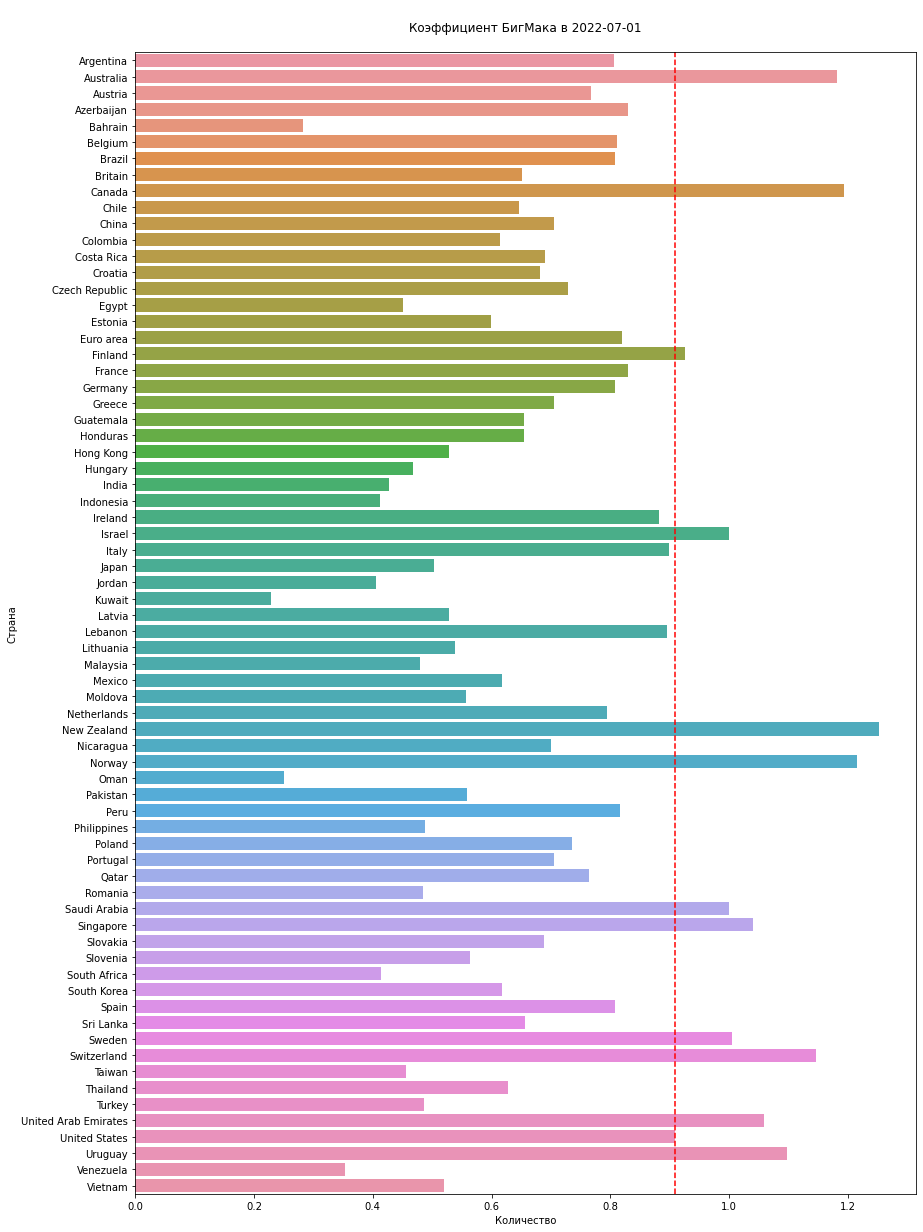

In [32]:
#Создадим график, на котором изобразим Страны и их покупательскую способность
plt.figure(figsize=(14,21)) #размер графика

sns.barplot(data=bigmac_2022, y='name', x='ratio') #переменные

plt.axvline(x=0.908289, linestyle='--', color='red') #коэффициент в США
plt.xlabel('Количество') #Назвасие Оси Х
plt.ylabel('Страна') #Назвасие Оси Y
plt.title("\nКоэффициент БигМака в 2022-07-01\n") #Название графика
plt.show()

In [46]:
#Посчитаем кол-во стран, у которых покупательская способность выше, чем у США
win_countries=bigmac_2022[(bigmac_2022['ratio']>0.908289)&(bigmac_2022['name']!='United States')].shape
win_countries

(12, 7)

In [48]:
#Запустим формулу, чтобы изучить эти страны
win_countries=bigmac_2022[(bigmac_2022['ratio']>0.908289)&(bigmac_2022['name']!='United States')]
list(win_countries['name'])

['Australia',
 'Canada',
 'Finland',
 'Israel',
 'New Zealand',
 'Norway',
 'Saudi Arabia',
 'Singapore',
 'Sweden',
 'Switzerland',
 'United Arab Emirates',
 'Uruguay']

## Вывод

Как мы можем заметить в 12 странах: Australia','Canada','Finland','Israel','New Zealand','Norway','Saudi Arabia','Singapore','Sweden','Switzerland','United Arab Emirates','Uruguay'покупательская способность выше, что говорит о более сильным курсе и покупательской способности

# Теперь поговорим о России

In [49]:
#Отсортируем данные, чтобы изучить только показатели по России
bigmac[bigmac['name']=='Russia']

,date,currency_code,name,local_price,dollar_ex,dollar_price,ratio
19,2000-04-01,RUB,Russia,39.50,28,1.41,0.248677
47,2001-04-01,RUB,Russia,35.00,28,1.25,0.220459
78,2002-04-01,RUB,Russia,39.00,31,1.26,0.222222
110,2003-04-01,RUB,Russia,41.00,31,1.32,0.232804
146,2004-05-01,RUB,Russia,42.00,29,1.45,0.255732
186,2005-06-01,RUB,Russia,42.00,28,1.50,0.264550
223,2006-01-01,RUB,Russia,46.00,28,1.64,0.289242
259,2006-05-01,RUB,Russia,48.00,27,1.78,0.313933
300,2007-01-01,RUB,Russia,49.00,26,1.88,0.331570
341,2007-06-01,RUB,Russia,52.00,25,2.08,0.366843


In [50]:
bigmac[bigmac['name']=='Russia'].shape

(36, 7)

In [51]:
# ЭЭЭЭЭЭЭЭХ, золотое время, когда БигМак стоил меньше сотки((( посчитаем кол-во этих строк
bigmac[(bigmac['name']=='Russia')&(bigmac['dollar_price']<=100)].shape

(36, 7)

In [52]:
#Теперь рассмотрим промежуток когда цена на БигМак была между 80 и 100 рублями в России
bigmac[(bigmac['name']=='Russia')&(bigmac['dollar_price'].isin(range(80,100)))].shape

(0, 7)

In [53]:
#отфильтруем данные по убыванию цены и возрастанию даты
bigmac_russia=bigmac[bigmac['name']=='Russia']
bigmac_russia.sort_values(by=['dollar_price', 'date'], ascending=[False, True])

,date,currency_code,name,local_price,dollar_ex,dollar_price,ratio
558,2011-07-01,RUB,Russia,75.00,27,2.78,0.490300
776,2013-07-01,RUB,Russia,87.00,32,2.72,0.479718
832,2014-01-01,RUB,Russia,89.00,33,2.70,0.476190
888,2014-07-01,RUB,Russia,89.00,34,2.62,0.462081
613,2012-01-01,RUB,Russia,81.00,31,2.61,0.460317
382,2008-06-01,RUB,Russia,59.00,23,2.57,0.453263
721,2013-01-01,RUB,Russia,72.88,30,2.43,0.428571
464,2010-01-01,RUB,Russia,70.00,29,2.41,0.425044
505,2010-07-01,RUB,Russia,71.00,30,2.37,0.417989
666,2012-07-01,RUB,Russia,75.00,32,2.34,0.412698


In [54]:
#Интересено рассмотреть максимум в России и мире
bigmac_russia_max = bigmac_russia['local_price'].max()
print('Самый дорогой Бигмак в России',bigmac_russia_max,'рублей')

Самый дорогой Бигмак в России 137.0 рублей


In [55]:
bigmac_price_max = bigmac['dollar_price'].max()
print('Самый дорогой Бигмак в мире',bigmac_price_max, 'долларов США')


Самый дорогой Бигмак в мире 11.25 долларов США


In [56]:
bigmac[bigmac['dollar_price']==11.25] #в Бразилии самый дорогой БигМак. Данная цена была установлена в 2013 году

,date,currency_code,name,local_price,dollar_ex,dollar_price,ratio
687,2013-01-01,BRL,Brazil,11.25,1,11.25,1.984127


In [57]:
#Исследуем среднюю и медианную величину
print(bigmac_russia.pivot_table(index='date',
                  values=['local_price','dollar_price'],
                  aggfunc=['mean','median']))

                   mean                   median            
           dollar_price local_price dollar_price local_price
date                                                        
2000-04-01         1.41       39.50         1.41       39.50
2001-04-01         1.25       35.00         1.25       35.00
2002-04-01         1.26       39.00         1.26       39.00
2003-04-01         1.32       41.00         1.32       41.00
2004-05-01         1.45       42.00         1.45       42.00
2005-06-01         1.50       42.00         1.50       42.00
2006-01-01         1.64       46.00         1.64       46.00
2006-05-01         1.78       48.00         1.78       48.00
2007-01-01         1.88       49.00         1.88       49.00
2007-06-01         2.08       52.00         2.08       52.00
2008-06-01         2.57       59.00         2.57       59.00
2009-07-01         2.09       67.00         2.09       67.00
2010-01-01         2.41       70.00         2.41       70.00
2010-07-01         2.37 

In [58]:
def get_dollar_price_cat(dollar_price): #задаем функцию
    if dollar_price <= 3.25:
        return 'Бери и не раздумывай'
    elif (dollar_price >3.25) and (dollar_price <= 7.5):
        return 'Пока терпимо'
    elif (dollar_price >7.5) and (dollar_price <= 11.25):
        return 'Ой, чет дорого'
    else:
        return 'Нет данных'
bigmac['Стоит_Покупать?'] = bigmac['dollar_price'].apply(get_dollar_price_cat) #создаем новую переменную
bigmac

,date,currency_code,name,local_price,dollar_ex,dollar_price,ratio,Стоит_Покупать?
0,2000-04-01,ARS,Argentina,2.50,1,2.50,0.440917,Бери и не раздумывай
1,2000-04-01,AUD,Australia,2.59,1,2.59,0.456790,Бери и не раздумывай
2,2000-04-01,BRL,Brazil,2.95,1,2.95,0.520282,Бери и не раздумывай
3,2000-04-01,GBP,Britain,1.90,1,1.90,0.335097,Бери и не раздумывай
4,2000-04-01,CAD,Canada,2.85,1,2.85,0.502646,Бери и не раздумывай
...,...,...,...,...,...,...,...,...
1941,2022-07-01,AED,United Arab Emirates,18.00,3,6.00,1.058201,Пока терпимо
1942,2022-07-01,USD,United States,5.15,1,5.15,0.908289,Пока терпимо
1943,2022-07-01,UYU,Uruguay,255.00,41,6.22,1.097002,Пока терпимо
1944,2022-07-01,VES,Venezuela,10.00,5,2.00,0.352734,Бери и не раздумывай


In [59]:
#рассмотрим сколько раз повторялось каждое новое значение
bigmac['Стоит_Покупать?'].value_counts()

Пока терпимо            1038
Бери и не раздумывай     887
Ой, чет дорого            21
Name: Стоит_Покупать?, dtype: int64

In [60]:
#а как обстоят дела с Россией?
bigmac[(bigmac['name']=='Russia')&(bigmac['Стоит_Покупать?']=='Ой, чет дорого')].shape

(0, 8)

In [61]:
bigmac[(bigmac['name']=='Russia')&(bigmac['Стоит_Покупать?']=='Бери и не раздумывай')].shape

(36, 8)

In [62]:
bigmac[(bigmac['name']=='Russia')&(bigmac['Стоит_Покупать?']=='Пока терпимо')].shape

(0, 8)

In [63]:
bigmac_av=bigmac.groupby(bigmac['date'].dt.year)['dollar_price'].mean()
bigmac_av

date
2000    2.323929
2001    2.157143
2002    2.301212
2003    2.425312
2004    2.444000
2005    2.715122
2006    2.790959
2007    3.072195
2008    3.649000
2009    3.463171
2010    3.702073
2011    4.011818
2012    3.840648
2013    4.039182
2014    3.908053
2015    3.641786
2016    3.587232
2017    3.794107
2018    3.729609
2019    3.634653
2020    3.717431
2021    3.792759
2022    3.958601
Name: dollar_price, dtype: float64

<BarContainer object of 23 artists>

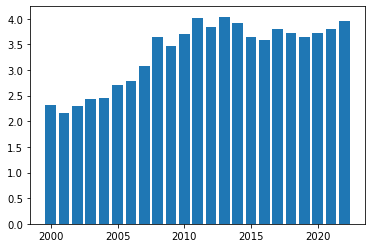

In [64]:
plt.bar(bigmac_av.index, bigmac_av)

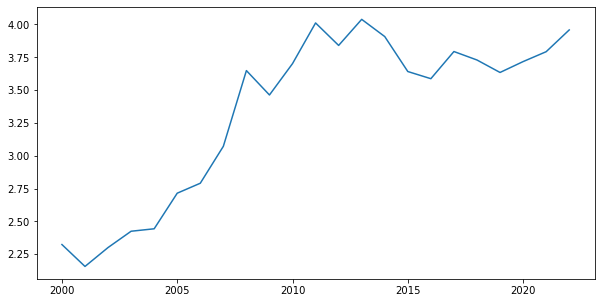

In [65]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(bigmac_av)

In [66]:
canada=bigmac[bigmac['name']=='Canada']
canada_trend=canada.groupby(canada['date'].dt.year)['local_price'].mean()

In [67]:
bigmac_russia_trend=bigmac_russia.groupby(bigmac_russia['date'].dt.year)['local_price'].mean()

In [68]:
uruguay=bigmac[bigmac['name']=='Uruguay']
uruguay_trend=uruguay.groupby(uruguay['date'].dt.year)['local_price'].mean()

In [69]:
costa_rica=bigmac[bigmac['name']=='Costa Rica']
costa_rica_trend=costa_rica.groupby(costa_rica['date'].dt.year)['local_price'].mean()

Text(0.5, 0.98, 'Анализ изменения цен на БигМак по четырем странам')

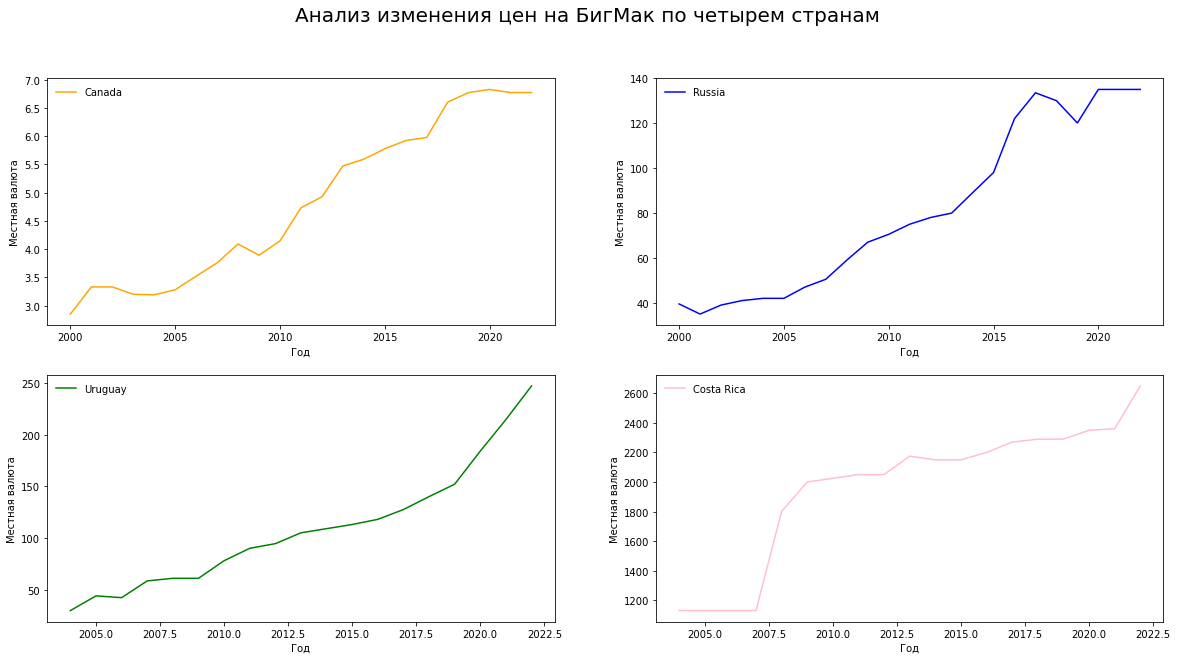

In [70]:
fig, ax = plt.subplots(2,2, figsize=(20,10))
ax[0][0].plot(canada_trend,c='orange')
ax[0][1].plot(bigmac_russia_trend,c='blue')
ax[1][0].plot(uruguay_trend,c='green')
ax[1][1].plot(costa_rica_trend,c='pink')

for axis in ax.ravel():
    axis.set_xlabel('Год')
    axis.set_ylabel('Местная валюта')
    
ax[0][0].legend(['Canada'],frameon=False)
ax[0][1].legend(['Russia'],frameon=False)
ax[1][0].legend(['Uruguay'],frameon=False)
ax[1][1].legend(['Costa Rica'],frameon=False)

fig.suptitle('Анализ изменения цен на БигМак по четырем странам', fontsize=20)

# Присвоим каждой стране континент и построим графики по каждому из континентов

In [71]:
# изменим формат даты на datetime64
bigmac['date'] = pd.to_datetime(bigmac.date)
bigmac['year'] = bigmac.date.dt.year
bigmac['month'] = bigmac.date.dt.month
bigmac.drop('date', axis=1, inplace=True)

In [72]:

grouped = bigmac.groupby(['year', 'currency_code', 'name'])[['local_price', 'dollar_ex', 'dollar_price']].mean().reset_index()

In [73]:
low_count = pd.DataFrame(grouped.name.value_counts())
low_count = low_count.reset_index()
low_count.columns = ['name', 'count']
name = low_count[low_count['count'] < 15]
name = [n for n in name.name]

In [74]:
for n in name:
    grouped['name'] = grouped['name'].str.replace(n, 'drop')
    
grouped = grouped[grouped.name != 'drop']

In [75]:
grouped['dollar_price'] = round(grouped['dollar_price'], 2)

In [76]:
grouped = grouped[grouped.name != 'Euro area']

In [77]:
continent = {'Argentina': 'South America',
             'Australia': 'Oceania/S. Africa',
             'Brazil': 'South America',
             'Canada': 'North America',
             'Switzerland': 'Western Europe',
             'Chile': 'South America',
             'China': 'East Asia',
             'Czech Republic': 'Eastern Europe',
             'Denmark': 'Western Europe',
             'Euro area': 'Europe',
             'Britain': 'Western Europe',
             'Hong Kong': 'East Asia',
             'Hungary': 'Eastern Europe',
             'Indonesia': 'South Asia',
             'Japan': 'East Asia',
             'South Korea': 'East Asia',
             'Mexico': 'North America',
             'Malaysia': 'South Asia',
             'New Zealand': 'Oceania/S. Africa',
             'Poland': 'Eastern Europe',
             'Russia': 'Eastern Europe',
             'Sweden': 'Western Europe',
             'Singapore': 'South Asia',
             'Thailand': 'South Asia',
             'Taiwan': 'East Asia',
             'United States': 'North America',
             'South Africa': 'Oceania/S. Africa',
             'Philippines': 'East Asia',
             'Norway': 'Western Europe',
             'Peru': 'South America',
             'Turkey': 'Middle East',
             'Egypt': 'Middle East',
             'Colombia': 'South America',
             'Costa Rica': 'North America',
             'Sri Lanka': 'South Asia',
             'Pakistan': 'Middle East',
             'Saudi Arabia': 'Middle East',
             'Ukraine': 'Eastern Europe',
             'Uruguay': 'South America'}

In [78]:
grouped['continent'] = grouped.name.map(continent)
grouped.groupby('continent')['name'].nunique()

continent
East Asia            6
Eastern Europe       5
Middle East          4
North America        4
Oceania/S. Africa    3
South America        6
South Asia           5
Western Europe       5
Name: name, dtype: int64

In [79]:
eastAsia = grouped[grouped.continent == 'East Asia'].copy()
eastEurope = grouped[grouped.continent == 'Eastern Europe'].copy()
midEast = grouped[grouped.continent == 'Middle East'].copy()
northAmerica = grouped[grouped.continent == 'North America'].copy()
oceania = grouped[grouped.continent == 'Oceania/S. Africa'].copy()
southAmerica = grouped[grouped.continent == 'South America'].copy()
southAsia = grouped[grouped.continent == 'South Asia'].copy()
westEurope = grouped[grouped.continent == 'Western Europe'].copy()

In [80]:
blocks = [eastAsia, eastEurope, midEast, northAmerica, oceania, southAmerica, southAsia, westEurope]

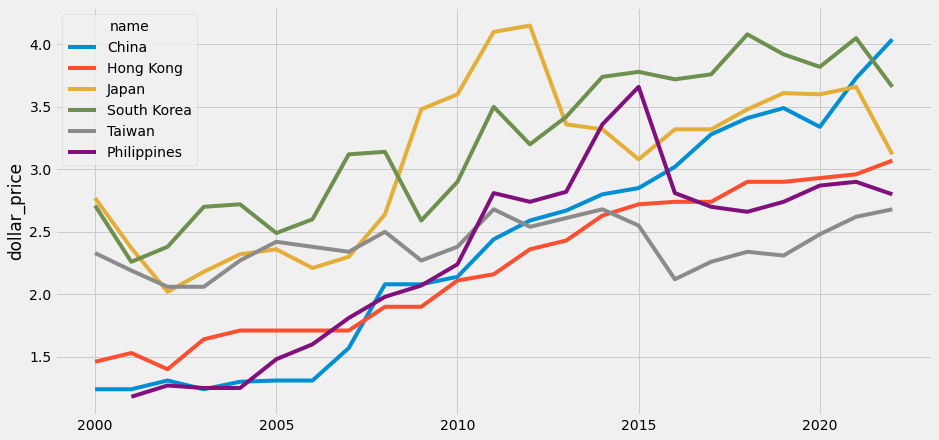

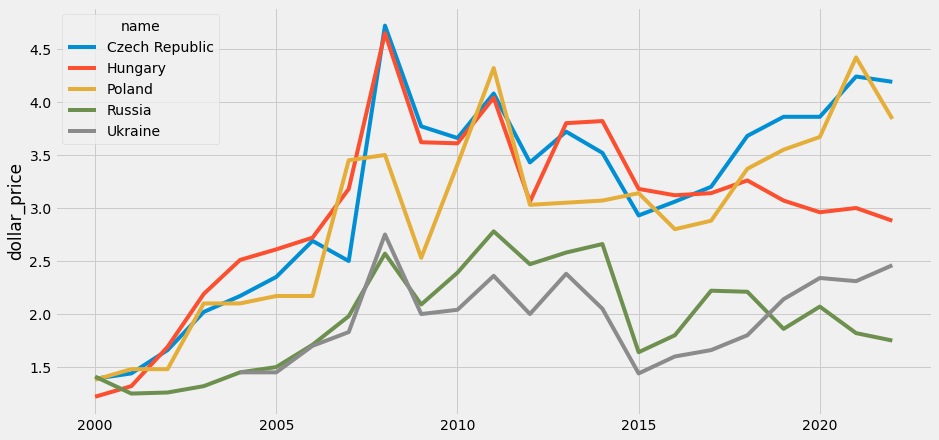

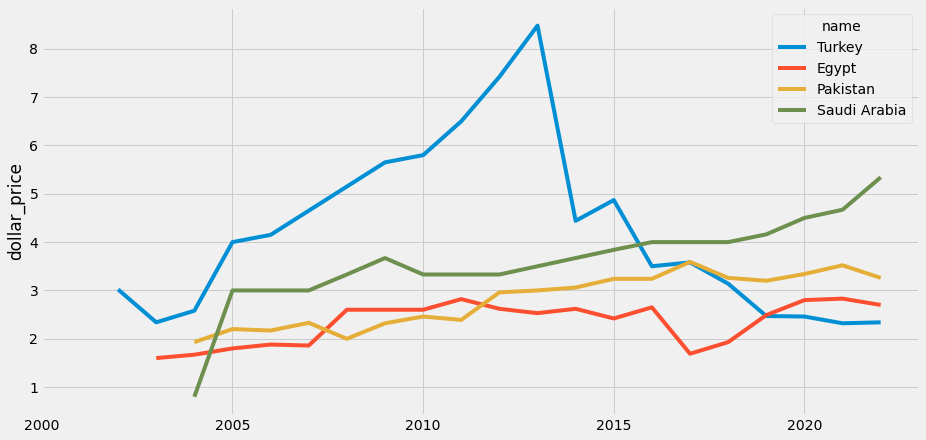

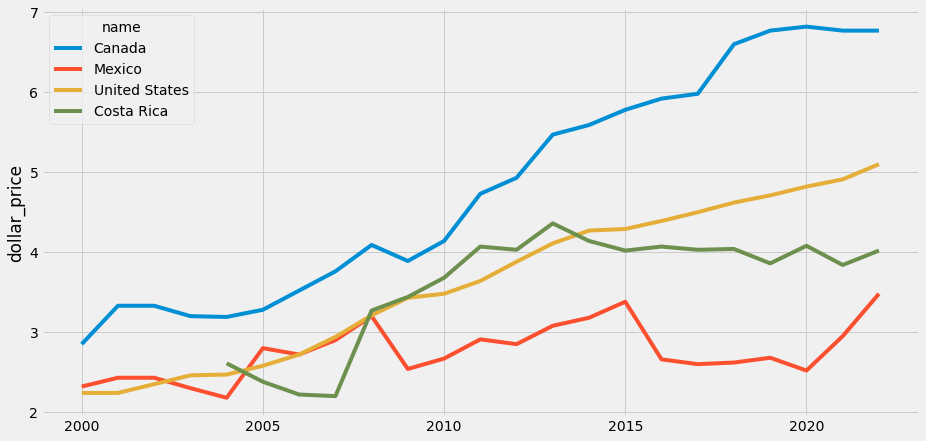

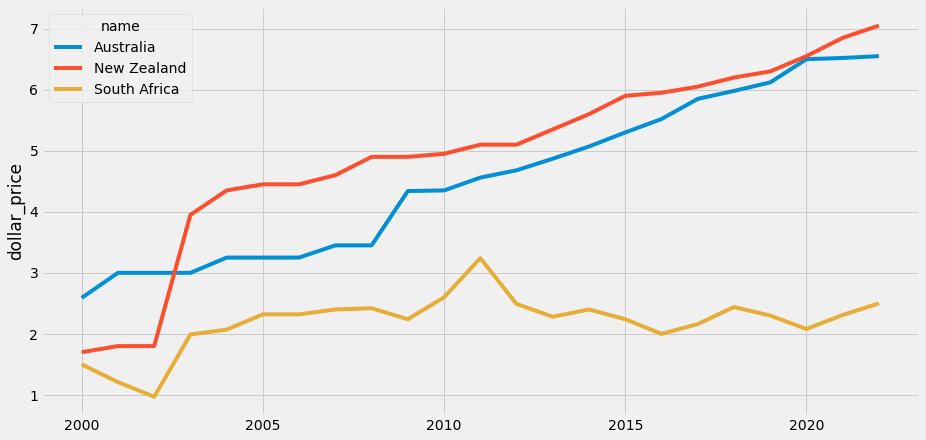

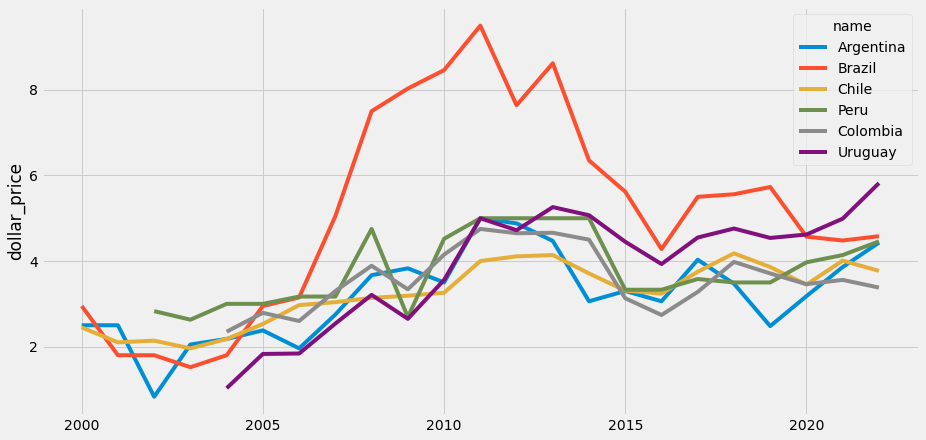

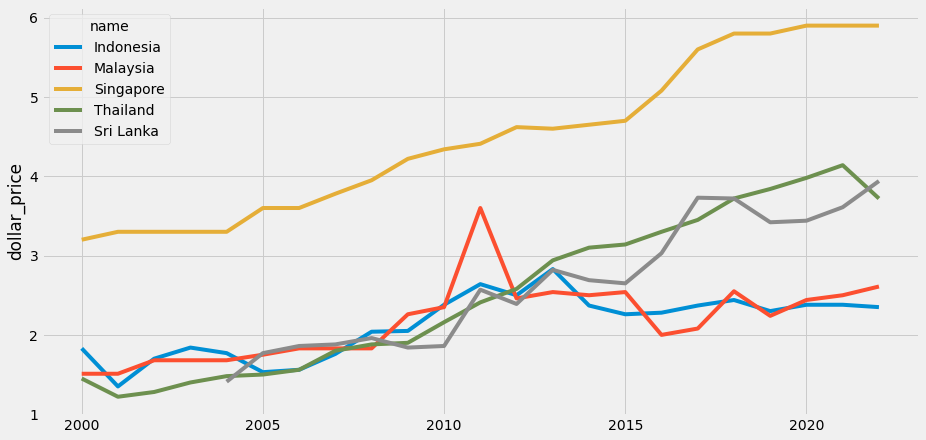

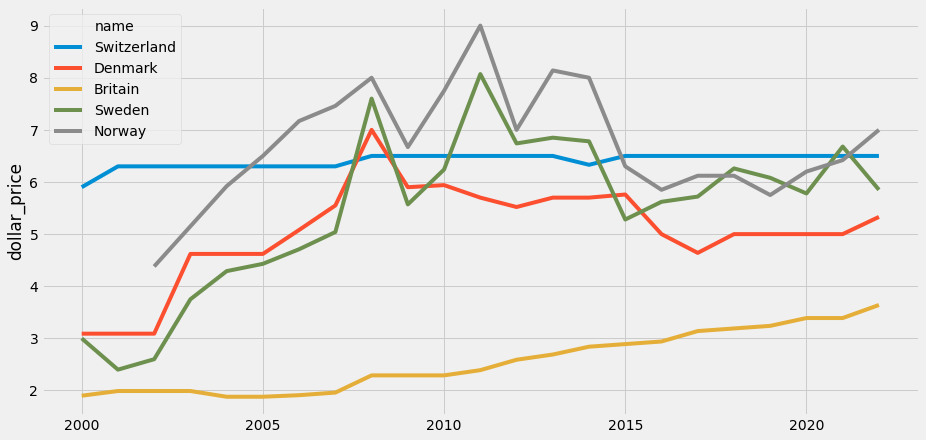

In [81]:
plt.style.use('fivethirtyeight')
for block in blocks:
    plt.figure(figsize=(14,7))
    sns.lineplot(data=block, x='year', y='dollar_price', hue='name')
    #plt.ylabel(None)
    plt.xlabel(None)
    plt.xticks([2000,2005,2010,2015,2020])
    plt.show()

# Подводим итоги

### *Из интересного хочется отметить*
Популярность индекса «Биг Мака» 
привела к тому, что некоторые аналитики стали использовать его в качестве одного из инструментов оценки ВВП разных стран. Так появился целый – конечно, шутливый – раздел экономики под названием «бургерономика».

### *Индекс «Биг Мака» нельзя использовать в качестве точного средства оценки, потому что у него есть несколько существенных минусов*

Прежде всего, в индексе могут участвовать только те страны, где есть McDonald’s. Например, в Африке существует индекс KFC, его используют для стран, где сеть McDonald’s не представлена, но можно приобрести фирменное ведерко курицы от конкурента.

*В некоторых развивающихся странах McDonald's может оказаться довольно дорогим заведением, особенно по сравнению с местными кафе, а большой сэндвич может стоить дороже других продуктов. Поэтому именно «Биг Мак» может пользоваться небольшим спросом.*

Кроме того, на стоимость меню McDonald’s влияет множество факторов: от расходов на производство, доставку и аренду до затрат на рекламу, поэтому такой индекс не подойдет для оценки экономики всех стран в мире. Не стоит забывать и о том, что на протяжении своего существования «Биг Мак» неоднократно менялся в размере и весе.